<a href="https://colab.research.google.com/github/yuneun92/class2022Spring/blob/main/%5B%EA%B8%B0%EB%A7%901%5D_speech_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0425
# **Audio Processing**
---

https://musiclab.chromeexperiments.com/Spectrogram/

x축이 시간, **y축이 주파수**.

### Fourier transform (분석용)
* spectrum은 주어진 signal에 대해 어떤 주파수 성분이 많이 있는지를 보는 것(낮은 / 높은 ...)
* spectrogram은 spectrum을 time 축으로 concatenate한 것
* 방법: signal (inner product) a series of complex phasors with different frequencies. 

  phasor를 다양한 주파수로 준비해서, 우리가 궁금해하는 signal에 곱해주면 그걸 갖고 plotting할 수 있고 그럼 또 하나의 스펙트럼이 나옴. 
* inner product는 일종의 correlation (즉, 해당 frequency가 얼마나 있는지 probing)
* 왜? sine phasor 안 쓰나? phase sensitivity 때문

### Filter (변환용)
* A --> function -->  B
* signal A --> filter --> signal B
* 신호 (time function: x축이 시간)를 입력으로 하는 함수를 filter라고 함
* 왜? filter 라고 부름? **이 함수의 목적이 특정 주파수에 대한 manipulation이므로.
(예: 어떤 주파수대를 작게, 크게, 통과, 제거 등)**
* 방법: weighted sum of signal's shifts **(두가지 방법: FIR, IIR)**

  * FIR: Y(k) = b<sub>1</sub>X(k) + b<sub>2</sub>X(k-1) + ... 
    - Y = H * X
  * IIR: a<sub>1</sub>Y(k) + a<sub>2</sub>Y(k-1) + ... = X(k)
    - Y = (1/H) * X

    => 각각 b1, b2, ...과 a1, a2, ...만 알면 원하는대로 filter할 수 있음. 
    만약 b1 = 1(혹은 a1 = 1)이고 b2(혹은 a2)부터 다 0이면 filter의 효과는 없음

### Auto correlation
* measuring pitch / F0

### RMS: root mean square
* measuring intensity(세기)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

### load / plot / play sound file

In [6]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')  #sample: 48,600개, sampling rate: 22050 (1초에 있는 신호의 개수)

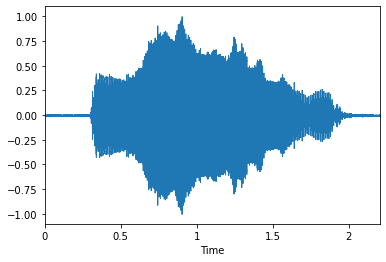

In [7]:
s = librosa.util.normalize(s) #전체 signal의 숫자의 절댓값의 최댓값으로 나눠줌. -> 가장 큰 수가 1이 되도록 정규화
librosa.display.waveplot(s, sr) #x축 시간으로 plotting
ipd.Audio(s[7000:12000], rate=sr) #아에이오우 중 '아'만 indexing

### Fourier Transform for Spectrogram
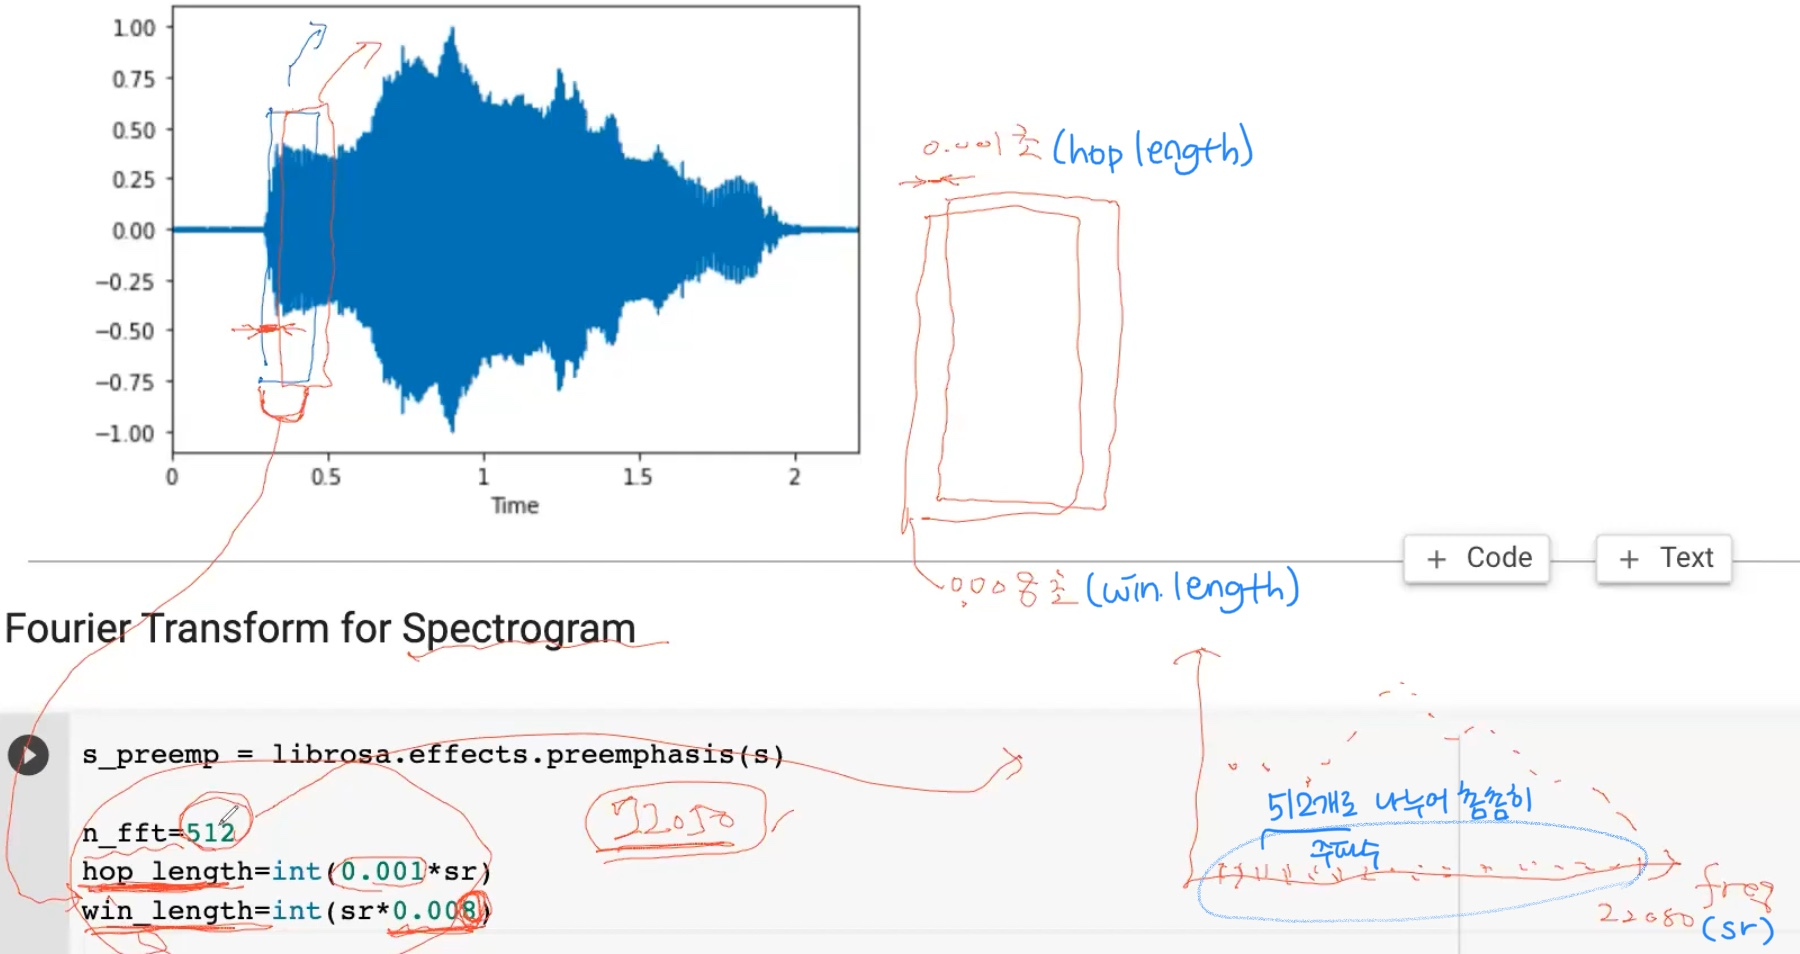

*abs

- signal이 있을 때 우리는 complex phasor과 그 signal을 inner product 함. 
complex phasor이므로 그 곱한 값은 복소수 형태. a+bi일 때 (a,b)를 좌표 상에서 나타낸 점의 원점으로부터의 길이가 abs. 


(0.0, 5000.0)

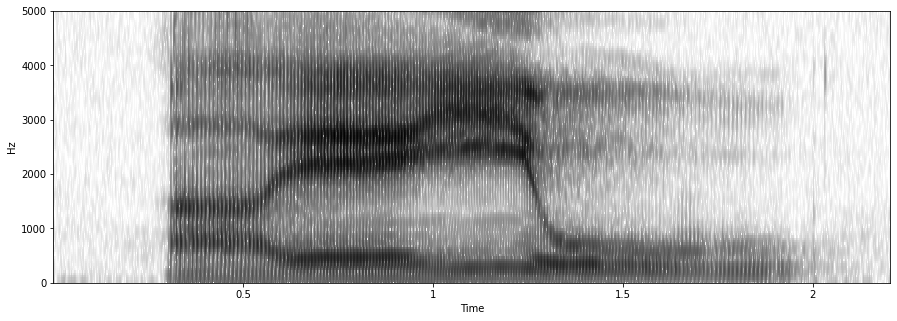

In [8]:
s_preemp = librosa.effects.preemphasis(s)

n_fft=512  #총 512개의 주파수. 
hop_length=int(0.001*sr)
win_length=int(sr*0.008) #스펙트로그램을 만들 땐 여러 장의 스펙트럼을 합치는 것: 각 스펙트럼의 시간을 정해줄 수 있음. 이 경우 0.008초

spec = librosa.stft(s_preemp, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window = 'hann')
magspec = np.abs(spec)
dBspec = librosa.amplitude_to_db(magspec, ref=np.max) #사람 귀에 맞는 소리로 바꾸기

plt.figure(figsize=(15, 5))
librosa.display.specshow(dBspec, sr=sr, x_coords = np.linspace(1, len(s), dBspec.shape[1])/sr , x_axis='time', y_axis='linear', cmap='Greys')
plt.ylim((0,5000))
#y축이 주파수

### Filter for audio transformation

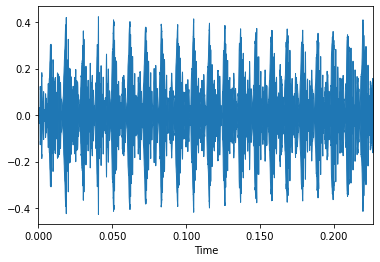

In [9]:
from scipy.signal import lfilter
sig = s[7000:12000]  #given signal에서 '아'만 인덱싱
sig = lfilter(np.array([1]), np.array([1]), sig, axis=0) #a와 b 값은 모두 array로(리스트로) 넣어줘야 함.  둘 다 1을 지정하면 소리가 변하지 않음. 
#b값을 1/2로 설정하면 소리가 부드러워짐. b와 a를 여러개 쓰고 싶으면 np.array([1/2, 1/2, 1/2, ...])이렇게 넣을 수 있음. 아무 숫자나 넣으면 오류
librosa.display.waveplot(sig, sr)
ipd.Audio(sig, rate=sr)

### RMS(Root Mean Square) for intensity

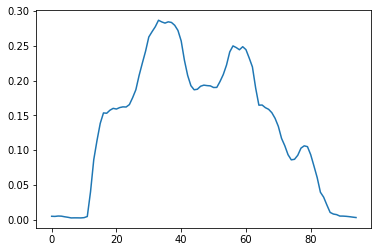

In [10]:
rms = librosa.feature.rms(s)
plt.plot(rms[0])

### Autocorrelation for pitch(F0) measurement

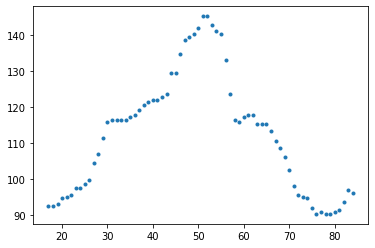

In [11]:
F0, voiced_flag, voiced_prob = librosa.pyin(s, 60, 200)
plt.plot(F0, '.')

# **Speech Processing**
> pulse train (=source 성대에서만 만들어지는 소리), vocal tract(구강) (=filter), Formants, LPC coeffiencts, Spectrum

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

### Generate pulse train (=source at larynx)

In [13]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

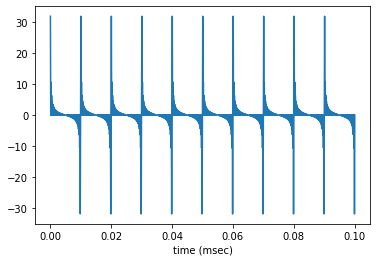

In [14]:
# parameter setting
amp = 1
sr = 10000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0):  #100부터 5000까지 F0만큼 뛰면서(increment): 100, 200, 300, ..., 5000 phasor를 만들어라
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s #우리가 원하는 source

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

#아래 그림에서 세로선이 하나의 pulse

### Filtering source through vocal tract: Formants

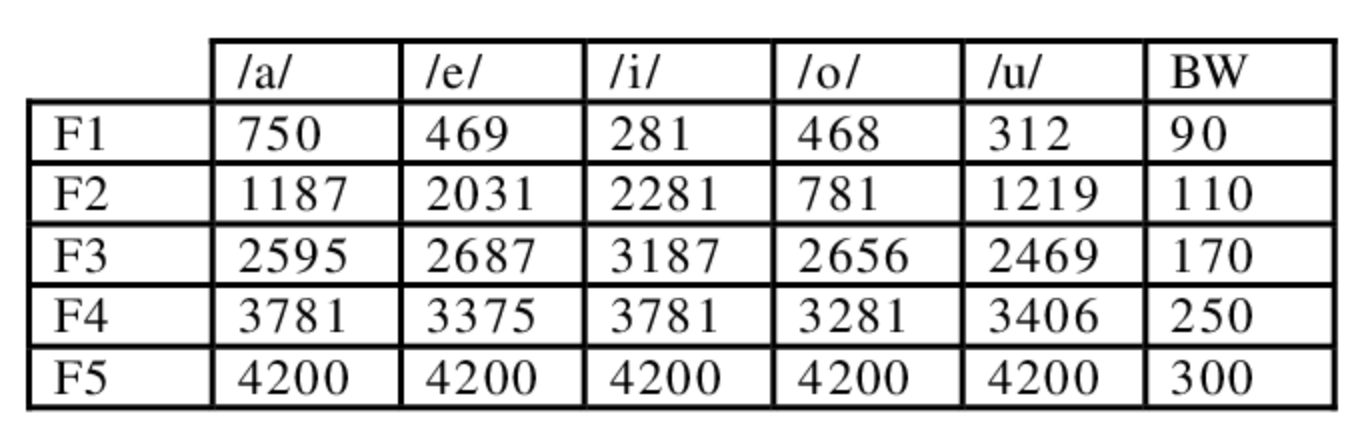

bw(bandwidth): 각 peak를 F1, F2, ...라고 함. 그에 해단되는 주파수값(frequency)은 x축! bandwidth는 각 산의 폭을 의미. 수가 작을수록 뾰족

In [ ]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW):   #F(formant): 산의 위치(주파수), BW(bandwidth): 산의 완만한 정도
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

In [ ]:
s = s_all #pulse train

In [ ]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
# /a/
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [ ]:
#입술로 인해 소리가 더 퍼져 나감. -> FIR을 만져서 입술의 효과를 냄
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

### LPC filter coefficients
* 모음 분석에만 이용

  Y = H*X  (FIR)


* H * Y = X (X는 모음일 때 성대에서 나는 소리 pulse train)
  어떤 모음이든, 음높이가 같으면 성대에서 나는 pulse train은 똑같음. 
* signal Y(주어진 모음)를 FIR 하면 pulse train X가 되는 H의 coefficients를 구하는 것임
* 즉, Y = 1/H * X 에서 H의 coefficients 구하는 것과 동일
* X의 관점에서 lfilter의 a 계수값 추정하는 것임




In [15]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)

In [16]:
import scipy
M = int(sr/1000+4) # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], M)

### Spectrum plotted from LPC coeffiencts

(0.0, 5000.0)

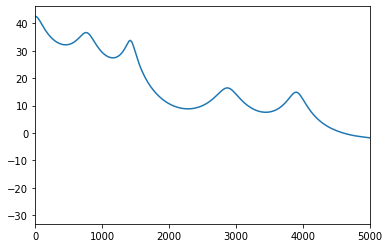

In [17]:
w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))


### Formants & Bandwidths computed from LPC coefficients (for Grad students only)

In [18]:
BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])

[  773.0751  1427.4038  2873.7573  3904.3184  4630.678   5151.7295
  7404.265   7795.8794  8694.367   9274.946  10049.233 ]
[ 229.41571  130.27097  307.47186  229.12651 1215.9471   542.4114
  202.3538   303.34442 1630.4275   210.64189 1169.2583 ]
